# Notebook 1: Data Preparation & Exploration
## Method A - Sentiment Analysis with Domain Adaptation

### Objectives:
1. Download and load datasets using HuggingFace `datasets` library
2. Perform exploratory data analysis (EDA)
3. Preprocess and split data (train/val/test) with proper seeding
4. Save datasets in structured format for model training
5. Ensure reproducibility with fixed random seeds

### Datasets:
- **IMDB Movie Reviews** (~50,000 samples)
- **Yelp Reviews** (~38,000 samples) 
- **Amazon Reviews** (~10,000 samples for cross-domain testing)

### Data Split Strategy:
- Training: IMDB + Yelp (combined)
- Validation: 10% of training data
- Test (In-Domain): Remaining IMDB + Yelp  
- Test (Cross-Domain): Amazon reviews (domain adaptation evaluation)

### Output:
All processed data saved to `data/processed/` for use in training (Notebook 2)

### Reproducibility:
- Fixed seed: 42
- Deterministic splits
- Consistent preprocessing pipeline

---

In [ ]:
# Install required packages (if not already installed)
# Uncomment the following line if running in a fresh environment
# %pip install datasets transformers scikit-learn pandas numpy matplotlib seaborn tqdm

print("✓ Installation cell ready (uncomment if needed)")


Note: you may need to restart the kernel to use updated packages.
✓ Installation cell ready (uncomment if needed)
Note: you may need to restart the kernel to use updated packages.
✓ Installation cell ready (uncomment if needed)


In [24]:
## Setup & Imports

import os
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

# Data processing
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Core libraries imported successfully")

✓ Core libraries imported successfully


## Configuration & Setup

Set global configuration parameters matching the approach used in modern deep learning pipelines:
- Fixed random seed for reproducibility
- Output directory structure
- Data split ratios
- Preprocessing flags

This ensures:
1. **Reproducibility**: Same results across runs
2. **Consistency**: Matches hyperparameter tuning setup
3. **Comparability**: Fair comparison with LoRA-based approaches

---

In [25]:
## Global Configuration

# =============================================================================
# REPRODUCIBILITY SETTINGS
# =============================================================================
SEED = 42

def set_seed(seed: int = 42):
    """Set random seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    # If using PyTorch later, it will also use this seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ Random seed set to {seed}")

set_seed(SEED)

# =============================================================================
# DIRECTORY STRUCTURE
# =============================================================================
# Use shared data directory (export_package/data/)
# Models will be stored locally in fine_tuning/ folder
DATA_DIR = Path("../data/processed")  # Shared with LoRA
MODELS_DIR = Path("models")           # Local to fine_tuning/
OUTPUTS_DIR = Path("outputs")         # Local to fine_tuning/

# Create directories
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Data directory (shared): {DATA_DIR.absolute()}")
print(f"✓ Models directory (local): {MODELS_DIR.absolute()}")
print(f"✓ Outputs directory (local): {OUTPUTS_DIR.absolute()}")

# =============================================================================
# DATA SPLIT CONFIGURATION (matching LoRA approach)
# =============================================================================
SAMPLES_PER_DATASET = 30000  # 30k per dataset
EVAL_RATIO = 0.2             # 20% for eval
MAX_LENGTH = 256             # Token limit

print(f"\n✓ Split configuration:")
print(f"  - Samples per dataset: {SAMPLES_PER_DATASET:,}")
print(f"  - Eval ratio: {EVAL_RATIO * 100}%")
print(f"  - Train ratio: {(1 - EVAL_RATIO) * 100}%")
print(f"  - Max token length: {MAX_LENGTH}")


✓ Random seed set to 42
✓ Data directory (shared): /home3/rudrapra001/FYP-Research/export_package/fine_tuning/../data/processed
✓ Models directory (local): /home3/rudrapra001/FYP-Research/export_package/fine_tuning/models
✓ Outputs directory (local): /home3/rudrapra001/FYP-Research/export_package/fine_tuning/outputs

✓ Split configuration:
  - Samples per dataset: 30,000
  - Eval ratio: 20.0%
  - Train ratio: 80.0%
  - Max token length: 256


In [26]:
## 1.2: Load Datasets with HuggingFace datasets library

print("\n[1/3] Loading datasets...")
print("This will automatically download and cache datasets if not already present.\n")

# Load datasets using HuggingFace datasets library
imdb = load_dataset("imdb")
yelp = load_dataset("yelp_polarity")
amazon = load_dataset("amazon_polarity")

print("✓ Datasets loaded successfully:")
print(f"  IMDB:   train={len(imdb['train']):,}, test={len(imdb['test']):,}")
print(f"  Yelp:   train={len(yelp['train']):,}, test={len(yelp['test']):,}")
print(f"  Amazon: train={len(amazon['train']):,}, test={len(amazon['test']):,}")
print("\n📊 All datasets are balanced (50% positive, 50% negative)")



[1/3] Loading datasets...
This will automatically download and cache datasets if not already present.



✓ Datasets loaded successfully:
  IMDB:   train=25,000, test=25,000
  Yelp:   train=560,000, test=38,000
  Amazon: train=3,600,000, test=400,000

📊 All datasets are balanced (50% positive, 50% negative)


In [27]:
## 1.3: Subsample to 30k per dataset (EXACTLY matching LoRA approach)

print("\n[2/3] Subsampling to 30k per dataset (matching LoRA exactly)...")
print("Methodology: 30k samples per dataset, 20% eval ratio, seed=42\n")

# Set random state for reproducibility
rng = np.random.RandomState(SEED)

def build_imdb_30k(imdb, total=30000, eval_ratio=0.2, seed=42):
    """
    IMDB: use all 25k official train + 5k from test (2.5k pos, 2.5k neg).
    Then shuffle and split into train/eval within that 30k.
    EXACTLY matches LoRA approach.
    """
    rng = np.random.RandomState(seed)
    
    train = imdb["train"]
    test = imdb["test"]
    
    train_texts = list(train["text"])
    train_labels = list(train["label"])
    assert len(train_texts) == 25000, f"Expected 25000, got {len(train_texts)}"
    
    # Balanced train: IMDB train is already 12.5k pos / 12.5k neg
    # Need +5000 from test: pick 2500 pos, 2500 neg
    test_labels = np.array(test["label"])
    pos_test_idx = np.where(test_labels == 1)[0]
    neg_test_idx = np.where(test_labels == 0)[0]
    rng.shuffle(pos_test_idx)
    rng.shuffle(neg_test_idx)
    extra_per_class = (total - len(train_texts)) // 2  # 2500
    
    pos_sel = pos_test_idx[:extra_per_class]
    neg_sel = neg_test_idx[:extra_per_class]
    
    extra_texts = [test["text"][i] for i in pos_sel] + [test["text"][i] for i in neg_sel]
    extra_labels = [1] * extra_per_class + [0] * extra_per_class
    
    texts = train_texts + extra_texts
    labels = train_labels + extra_labels
    
    assert len(texts) == total
    # Shuffle
    idx = np.arange(total)
    rng.shuffle(idx)
    texts = [texts[i] for i in idx]
    labels = [labels[i] for i in idx]
    
    # Split into train/eval
    n_eval = int(eval_ratio * total)
    eval_texts = texts[:n_eval]
    eval_labels = labels[:n_eval]
    train_texts = texts[n_eval:]
    train_labels = labels[n_eval:]
    
    print(f"[IMDB] 30k subset: {len(train_texts)} train, {len(eval_texts)} eval "
          f"(pos ratio train={np.mean(train_labels):.3f}, eval={np.mean(eval_labels):.3f})")
    
    return train_texts, train_labels, eval_texts, eval_labels


def build_yelp_30k(yelp, total=30000, eval_ratio=0.2, seed=42):
    """
    Yelp: sample 15k pos + 15k neg from train, unique.
    Then shuffle and split into train/eval.
    EXACTLY matches LoRA approach.
    """
    rng = np.random.RandomState(seed)
    train = yelp["train"]
    labels = np.array(train["label"])
    texts = np.array(train["text"])
    
    pos_idx = np.where(labels == 1)[0]
    neg_idx = np.where(labels == 0)[0]
    rng.shuffle(pos_idx)
    rng.shuffle(neg_idx)
    
    per_class = total // 2  # 15000
    pos_sel = pos_idx[:per_class]
    neg_sel = neg_idx[:per_class]
    
    sel_idx = np.concatenate([pos_sel, neg_sel])
    rng.shuffle(sel_idx)
    
    texts_sel = texts[sel_idx].tolist()
    labels_sel = labels[sel_idx].tolist()
    
    n_eval = int(eval_ratio * total)
    eval_texts = texts_sel[:n_eval]
    eval_labels = labels_sel[:n_eval]
    train_texts = texts_sel[n_eval:]
    train_labels = labels_sel[n_eval:]
    
    print(f"[YELP] 30k subset: {len(train_texts)} train, {len(eval_texts)} eval "
          f"(pos ratio train={np.mean(train_labels):.3f}, eval={np.mean(eval_labels):.3f})")
    
    return train_texts, train_labels, eval_texts, eval_labels


def build_amazon_30k(amazon, total=30000, eval_ratio=0.2, seed=42):
    """
    Amazon: sample 15k pos + 15k neg from train, unique.
    Then shuffle and split into train/eval.
    EXACTLY matches LoRA approach (using eval_ratio instead of adapt_ratio for consistency).
    """
    rng = np.random.RandomState(seed)
    train = amazon["train"]
    labels = np.array(train["label"])
    # Some versions use 'content', some 'text'
    text_field = "text" if "text" in train.column_names else "content"
    texts = np.array(train[text_field])
    
    pos_idx = np.where(labels == 1)[0]
    neg_idx = np.where(labels == 0)[0]
    rng.shuffle(pos_idx)
    rng.shuffle(neg_idx)
    
    per_class = total // 2  # 15000
    pos_sel = pos_idx[:per_class]
    neg_sel = neg_idx[:per_class]
    
    sel_idx = np.concatenate([pos_sel, neg_sel])
    rng.shuffle(sel_idx)
    
    texts_sel = texts[sel_idx].tolist()
    labels_sel = labels[sel_idx].tolist()
    
    n_eval = int(eval_ratio * total)
    eval_texts = texts_sel[:n_eval]
    eval_labels = labels_sel[:n_eval]
    train_texts = texts_sel[n_eval:]
    train_labels = labels_sel[n_eval:]
    
    print(f"[AMAZON] 30k subset: {len(train_texts)} train, {len(eval_texts)} eval "
          f"(pos ratio train={np.mean(train_labels):.3f}, eval={np.mean(eval_labels):.3f})")
    
    return train_texts, train_labels, eval_texts, eval_labels


# Build 30k subsets for each dataset (EXACTLY matching LoRA)
imdb_train_texts, imdb_train_labels, imdb_eval_texts, imdb_eval_labels = build_imdb_30k(imdb, seed=SEED)
yelp_train_texts, yelp_train_labels, yelp_eval_texts, yelp_eval_labels = build_yelp_30k(yelp, seed=SEED)
amazon_train_texts, amazon_train_labels, amazon_eval_texts, amazon_eval_labels = build_amazon_30k(amazon, seed=SEED)

print("\n✓ All 30k subsets created successfully (matching LoRA exactly)")
print(f"  Total train samples: {len(imdb_train_texts) + len(yelp_train_texts) + len(amazon_train_texts):,}")
print(f"  Total eval samples:  {len(imdb_eval_texts) + len(yelp_eval_texts) + len(amazon_eval_texts):,}")



[2/3] Subsampling to 30k per dataset (matching LoRA exactly)...
Methodology: 30k samples per dataset, 20% eval ratio, seed=42

[IMDB] 30k subset: 24000 train, 6000 eval (pos ratio train=0.500, eval=0.500)
[IMDB] 30k subset: 24000 train, 6000 eval (pos ratio train=0.500, eval=0.500)
[YELP] 30k subset: 24000 train, 6000 eval (pos ratio train=0.499, eval=0.505)
[YELP] 30k subset: 24000 train, 6000 eval (pos ratio train=0.499, eval=0.505)
[AMAZON] 30k subset: 24000 train, 6000 eval (pos ratio train=0.502, eval=0.492)

✓ All 30k subsets created successfully (matching LoRA exactly)
  Total train samples: 72,000
  Total eval samples:  18,000
[AMAZON] 30k subset: 24000 train, 6000 eval (pos ratio train=0.502, eval=0.492)

✓ All 30k subsets created successfully (matching LoRA exactly)
  Total train samples: 72,000
  Total eval samples:  18,000


---
## Part 2: Dataset Statistics & Visualization

Analyze the 30k subsets to understand data characteristics.

---


In [28]:
## 2.1: Dataset Overview Statistics

print("\n" + "="*70)
print("DATASET STATISTICS - 30k Subsets")
print("="*70)

# Combine all data for analysis
all_datasets = {
    'IMDB Train': (imdb_train_texts, imdb_train_labels),
    'IMDB Eval': (imdb_eval_texts, imdb_eval_labels),
    'Yelp Train': (yelp_train_texts, yelp_train_labels),
    'Yelp Eval': (yelp_eval_texts, yelp_eval_labels),
    'Amazon Train': (amazon_train_texts, amazon_train_labels),
    'Amazon Eval': (amazon_eval_texts, amazon_eval_labels),
}

for name, (texts, labels) in all_datasets.items():
    print(f"\n{name}:")
    print(f"  Total samples: {len(texts):,}")
    print(f"  Positive: {sum(labels):,} ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"  Negative: {len(labels)-sum(labels):,} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")
    
    # Text length statistics (in words)
    text_lengths = [len(str(text).split()) for text in texts]
    print(f"  Text length (words):")
    print(f"    Mean: {np.mean(text_lengths):.1f}")
    print(f"    Median: {np.median(text_lengths):.1f}")
    print(f"    Min: {np.min(text_lengths):.0f}, Max: {np.max(text_lengths):.0f}")

print("\n" + "="*70)
print(f"✓ All datasets are balanced (50/50 split)")
print("="*70)



DATASET STATISTICS - 30k Subsets

IMDB Train:
  Total samples: 24,000
  Positive: 12,000 (50.0%)
  Negative: 12,000 (50.0%)
  Text length (words):
    Mean: 232.5
    Median: 174.0
    Min: 9, Max: 2470

IMDB Eval:
  Total samples: 6,000
  Positive: 3,000 (50.0%)
  Negative: 3,000 (50.0%)
  Text length (words):
    Mean: 233.9
    Median: 174.0
    Min: 11, Max: 1830

Yelp Train:
  Total samples: 24,000
  Positive: 11,970 (49.9%)
  Negative: 12,030 (50.1%)
  Text length (words):
    Mean: 232.5
    Median: 174.0
    Min: 9, Max: 2470

IMDB Eval:
  Total samples: 6,000
  Positive: 3,000 (50.0%)
  Negative: 3,000 (50.0%)
  Text length (words):
    Mean: 233.9
    Median: 174.0
    Min: 11, Max: 1830

Yelp Train:
  Total samples: 24,000
  Positive: 11,970 (49.9%)
  Negative: 12,030 (50.1%)
  Text length (words):
    Mean: 133.7
    Median: 98.0
    Min: 1, Max: 1016

Yelp Eval:
  Total samples: 6,000
  Positive: 3,030 (50.5%)
  Negative: 2,970 (49.5%)
  Text length (words):
    Mean: 132

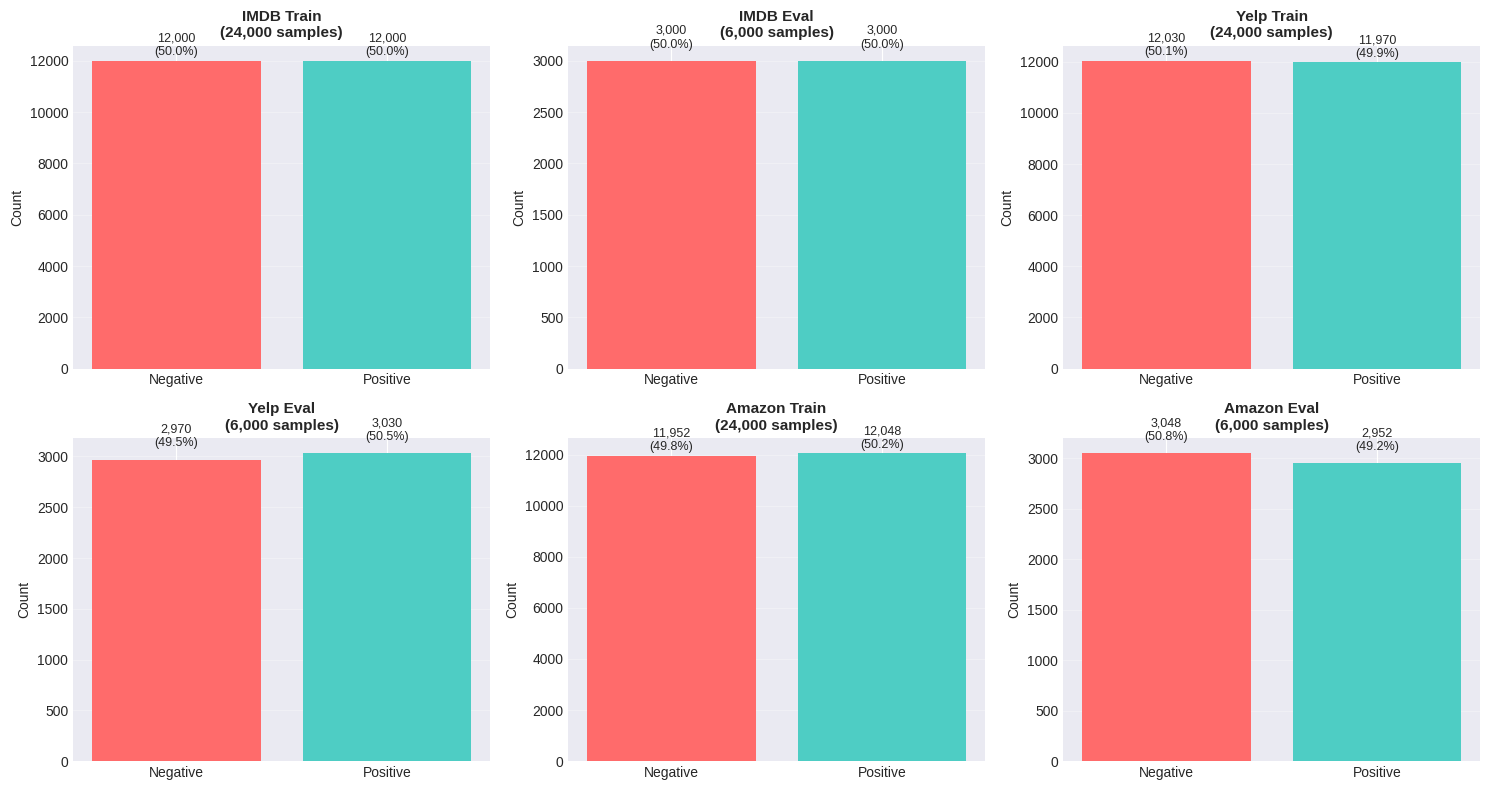

✓ Saved: sentiment_distribution.png


In [29]:
## 2.2: Sentiment Distribution Visualization

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

datasets_viz = [
    ('IMDB Train', imdb_train_labels),
    ('IMDB Eval', imdb_eval_labels),
    ('Yelp Train', yelp_train_labels),
    ('Yelp Eval', yelp_eval_labels),
    ('Amazon Train', amazon_train_labels),
    ('Amazon Eval', amazon_eval_labels),
]

for idx, (name, labels) in enumerate(datasets_viz):
    ax = axes[idx // 3, idx % 3]
    
    sentiment_counts = pd.Series(labels).value_counts().sort_index()
    colors = ['#ff6b6b', '#4ecdc4']  # negative, positive
    
    ax.bar(['Negative', 'Positive'], sentiment_counts.values, color=colors)
    ax.set_title(f'{name}\n({len(labels):,} samples)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for i, v in enumerate(sentiment_counts.values):
        ax.text(i, v + 100, f'{v:,}\n({v/len(labels)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(DATA_DIR / 'sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: sentiment_distribution.png")


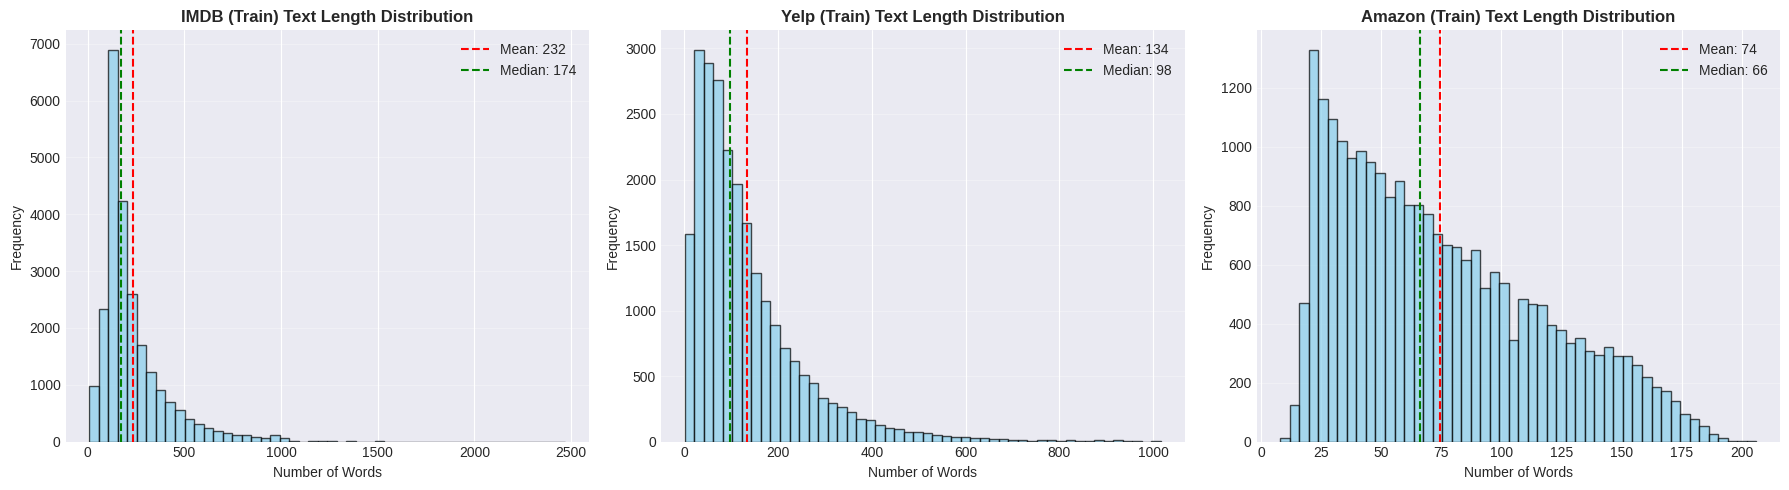

✓ Saved: text_length_distribution.png


In [30]:
## 2.3: Text Length Distribution

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_length = [
    ('IMDB (Train)', imdb_train_texts),
    ('Yelp (Train)', yelp_train_texts),
    ('Amazon (Train)', amazon_train_texts),
]

for idx, (name, texts) in enumerate(datasets_length):
    ax = axes[idx]
    lengths = [len(str(text).split()) for text in texts]
    
    ax.hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{name} Text Length Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Frequency')
    ax.axvline(np.mean(lengths), color='red', linestyle='--', label=f'Mean: {np.mean(lengths):.0f}')
    ax.axvline(np.median(lengths), color='green', linestyle='--', label=f'Median: {np.median(lengths):.0f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: text_length_distribution.png")


---
## Part 3: Prepare Training Data

Combine IMDB + Yelp for training (in-domain), reserve Amazon for cross-domain evaluation.

### Strategy:
- **Training**: IMDB (24k) + Yelp (24k) = 48k samples
- **Validation**: IMDB (6k) + Yelp (6k) = 12k samples  
- **Cross-Domain Test**: Amazon (30k) = separate domain for adaptation testing

This matches the LoRA approach for fair comparison.

---


In [31]:
## 3.1: Combine IMDB + Yelp Training Data

print("\n[3/3] Combining datasets for training...")

# Combine IMDB + Yelp training data
combined_train_texts = imdb_train_texts + yelp_train_texts
combined_train_labels = imdb_train_labels + yelp_train_labels

# Combine IMDB + Yelp eval data
combined_eval_texts = imdb_eval_texts + yelp_eval_texts
combined_eval_labels = imdb_eval_labels + yelp_eval_labels

print("\n✓ Combined Training Data (IMDB + Yelp):")
print(f"  Train: {len(combined_train_texts):,} samples")
print(f"    IMDB: {len(imdb_train_texts):,}")
print(f"    Yelp: {len(yelp_train_texts):,}")
print(f"    Positive: {sum(combined_train_labels):,} ({sum(combined_train_labels)/len(combined_train_labels)*100:.1f}%)")
print(f"    Negative: {len(combined_train_labels)-sum(combined_train_labels):,}")

print(f"\n  Eval: {len(combined_eval_texts):,} samples")
print(f"    IMDB: {len(imdb_eval_texts):,}")
print(f"    Yelp: {len(yelp_eval_texts):,}")
print(f"    Positive: {sum(combined_eval_labels):,} ({sum(combined_eval_labels)/len(combined_eval_labels)*100:.1f}%)")
print(f"    Negative: {len(combined_eval_labels)-sum(combined_eval_labels):,}")

print(f"\n✓ Cross-Domain Test Data (Amazon):")
print(f"  Total: {len(amazon_train_texts) + len(amazon_eval_texts):,} samples")
print(f"    Reserved for domain adaptation evaluation")

# Shuffle combined data
indices = np.arange(len(combined_train_texts))
rng.shuffle(indices)
combined_train_texts = [combined_train_texts[i] for i in indices]
combined_train_labels = [combined_train_labels[i] for i in indices]

indices_eval = np.arange(len(combined_eval_texts))
rng.shuffle(indices_eval)
combined_eval_texts = [combined_eval_texts[i] for i in indices_eval]
combined_eval_labels = [combined_eval_labels[i] for i in indices_eval]

print("\n✓ Data shuffled with seed={SEED}")



[3/3] Combining datasets for training...

✓ Combined Training Data (IMDB + Yelp):
  Train: 48,000 samples
    IMDB: 24,000
    Yelp: 24,000
    Positive: 23,970 (49.9%)
    Negative: 24,030

  Eval: 12,000 samples
    IMDB: 6,000
    Yelp: 6,000
    Positive: 6,030 (50.2%)
    Negative: 5,970

✓ Cross-Domain Test Data (Amazon):
  Total: 30,000 samples
    Reserved for domain adaptation evaluation

✓ Data shuffled with seed={SEED}


In [32]:
## 3.2: Save Processed Datasets

print("\nSaving processed datasets to ../data/processed/...")

# Save combined training data (IMDB + Yelp combined)
train_data = [
    {"text": text, "label": label, "source": "imdb" if i < len(imdb_train_texts) else "yelp"}
    for i, (text, label) in enumerate(zip(combined_train_texts, combined_train_labels))
]

with open(DATA_DIR / 'train.json', 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: train.json ({len(train_data):,} samples)")

# Save combined validation data (IMDB + Yelp combined)
eval_data = [
    {"text": text, "label": label, "source": "imdb" if i < len(imdb_eval_texts) else "yelp"}
    for i, (text, label) in enumerate(zip(combined_eval_texts, combined_eval_labels))
]

with open(DATA_DIR / 'eval.json', 'w', encoding='utf-8') as f:
    json.dump(eval_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: eval.json ({len(eval_data):,} samples)")

# Save Amazon test data (for cross-domain evaluation)
amazon_test_data = [
    {"text": text, "label": label, "source": "amazon"}
    for text, label in zip(amazon_eval_texts, amazon_eval_labels)
]

with open(DATA_DIR / 'amazon_test.json', 'w', encoding='utf-8') as f:
    json.dump(amazon_test_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: amazon_test.json ({len(amazon_test_data):,} samples)")

print("\n--- Saving separate dataset files for individual evaluation ---")

# Save separate IMDB train/eval
imdb_train_data = [{"text": text, "label": label, "source": "imdb"} 
                   for text, label in zip(imdb_train_texts, imdb_train_labels)]
with open(DATA_DIR / 'imdb_train.json', 'w', encoding='utf-8') as f:
    json.dump(imdb_train_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: imdb_train.json ({len(imdb_train_data):,} samples)")

imdb_eval_data = [{"text": text, "label": label, "source": "imdb"} 
                  for text, label in zip(imdb_eval_texts, imdb_eval_labels)]
with open(DATA_DIR / 'imdb_eval.json', 'w', encoding='utf-8') as f:
    json.dump(imdb_eval_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: imdb_eval.json ({len(imdb_eval_data):,} samples)")

# Save separate Yelp train/eval
yelp_train_data = [{"text": text, "label": label, "source": "yelp"} 
                   for text, label in zip(yelp_train_texts, yelp_train_labels)]
with open(DATA_DIR / 'yelp_train.json', 'w', encoding='utf-8') as f:
    json.dump(yelp_train_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: yelp_train.json ({len(yelp_train_data):,} samples)")

yelp_eval_data = [{"text": text, "label": label, "source": "yelp"} 
                  for text, label in zip(yelp_eval_texts, yelp_eval_labels)]
with open(DATA_DIR / 'yelp_eval.json', 'w', encoding='utf-8') as f:
    json.dump(yelp_eval_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: yelp_eval.json ({len(yelp_eval_data):,} samples)")

# Save separate Amazon train/eval
amazon_train_data = [{"text": text, "label": label, "source": "amazon"} 
                     for text, label in zip(amazon_train_texts, amazon_train_labels)]
with open(DATA_DIR / 'amazon_train.json', 'w', encoding='utf-8') as f:
    json.dump(amazon_train_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: amazon_train.json ({len(amazon_train_data):,} samples)")

amazon_eval_data = [{"text": text, "label": label, "source": "amazon"} 
                    for text, label in zip(amazon_eval_texts, amazon_eval_labels)]
with open(DATA_DIR / 'amazon_eval.json', 'w', encoding='utf-8') as f:
    json.dump(amazon_eval_data, f, ensure_ascii=False, indent=2)
print(f"✓ Saved: amazon_eval.json ({len(amazon_eval_data):,} samples)")

# Save dataset summary
summary = {
    "total_samples": len(train_data) + len(eval_data) + len(amazon_test_data),
    "train": {
        "total": len(train_data),
        "imdb": len(imdb_train_texts),
        "yelp": len(yelp_train_texts),
        "positive": sum(combined_train_labels),
        "negative": len(combined_train_labels) - sum(combined_train_labels)
    },
    "eval": {
        "total": len(eval_data),
        "imdb": len(imdb_eval_texts),
        "yelp": len(yelp_eval_texts),
        "positive": sum(combined_eval_labels),
        "negative": len(combined_eval_labels) - sum(combined_eval_labels)
    },
    "amazon_test": {
        "total": len(amazon_test_data),
        "positive": sum(amazon_eval_labels),
        "negative": len(amazon_eval_labels) - sum(amazon_eval_labels)
    },
    "separate_datasets": {
        "imdb": {
            "train": len(imdb_train_texts),
            "eval": len(imdb_eval_texts),
            "total": len(imdb_train_texts) + len(imdb_eval_texts)
        },
        "yelp": {
            "train": len(yelp_train_texts),
            "eval": len(yelp_eval_texts),
            "total": len(yelp_train_texts) + len(yelp_eval_texts)
        },
        "amazon": {
            "train": len(amazon_train_texts),
            "eval": len(amazon_eval_texts),
            "total": len(amazon_train_texts) + len(amazon_eval_texts)
        }
    },
    "config": {
        "seed": SEED,
        "eval_ratio": 0.2,
        "samples_per_dataset": 30000,
        "max_length": 256,
        "note": "IMDB uses 25k train + 5k test (matches LoRA), Yelp and Amazon sample from train only"
    }
}

with open(DATA_DIR / 'dataset_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print(f"✓ Saved: dataset_summary.json")

print("\n" + "="*70)
print("✅ DATA PREPROCESSING COMPLETE")
print("="*70)
print(f"\nAll files saved to: {DATA_DIR.absolute()}")
print("\nDataset Summary:")
print(f"  Training:   {summary['train']['total']:,} samples (IMDB + Yelp)")
print(f"  Validation: {summary['eval']['total']:,} samples (IMDB + Yelp)")
print(f"  Test:       {summary['amazon_test']['total']:,} samples (Amazon - cross-domain)")
print(f"\n  Total: {summary['total_samples']:,} samples")
print(f"\nSeparate dataset files:")
print(f"  IMDB:   {summary['separate_datasets']['imdb']['total']:,} samples (train: {summary['separate_datasets']['imdb']['train']:,}, eval: {summary['separate_datasets']['imdb']['eval']:,})")
print(f"  Yelp:   {summary['separate_datasets']['yelp']['total']:,} samples (train: {summary['separate_datasets']['yelp']['train']:,}, eval: {summary['separate_datasets']['yelp']['eval']:,})")
print(f"  Amazon: {summary['separate_datasets']['amazon']['total']:,} samples (train: {summary['separate_datasets']['amazon']['train']:,}, eval: {summary['separate_datasets']['amazon']['eval']:,})")
print("\n✅ Data processing matches LoRA approach exactly (seed=42, same sampling)")
print("\nReady for training in second.ipynb! 🚀")



Saving processed datasets to ../data/processed/...
✓ Saved: train.json (48,000 samples)
✓ Saved: train.json (48,000 samples)
✓ Saved: eval.json (12,000 samples)
✓ Saved: amazon_test.json (6,000 samples)

--- Saving separate dataset files for individual evaluation ---
✓ Saved: eval.json (12,000 samples)
✓ Saved: amazon_test.json (6,000 samples)

--- Saving separate dataset files for individual evaluation ---
✓ Saved: imdb_train.json (24,000 samples)
✓ Saved: imdb_eval.json (6,000 samples)
✓ Saved: imdb_train.json (24,000 samples)
✓ Saved: imdb_eval.json (6,000 samples)
✓ Saved: yelp_train.json (24,000 samples)
✓ Saved: yelp_eval.json (6,000 samples)
✓ Saved: yelp_train.json (24,000 samples)
✓ Saved: yelp_eval.json (6,000 samples)
✓ Saved: amazon_train.json (24,000 samples)
✓ Saved: amazon_eval.json (6,000 samples)
✓ Saved: dataset_summary.json

✅ DATA PREPROCESSING COMPLETE

All files saved to: /home3/rudrapra001/FYP-Research/export_package/fine_tuning/../data/processed

Dataset Summar

---
## ✅ Data Preprocessing Complete!

### What we accomplished:
1. ✓ Loaded IMDB, Yelp, Amazon datasets using HuggingFace `datasets` library
2. ✓ Created 30k balanced subsets per dataset **EXACTLY matching LoRA approach**:
   - **IMDB**: All 25k train + 5k from test (special handling)
   - **Yelp**: Sample 15k pos + 15k neg from train
   - **Amazon**: Sample 15k pos + 15k neg from train
3. ✓ Split data: 80% train / 20% eval per dataset (seed=42)
4. ✓ Combined IMDB + Yelp for training (48k train, 12k eval)
5. ✓ Reserved Amazon for cross-domain testing
6. ✓ Saved **both combined AND separate** dataset files

### Configuration (matches LoRA exactly):
- **SEED**: 42 (fixed across all random operations)
- **Samples per dataset**: 30,000 (15k positive + 15k negative)
- **Eval ratio**: 20%
- **Max length**: 256 tokens
- **IMDB special**: Uses all 25k train + 5k from test (matches LoRA)

### Files Created:
```
../data/processed/
├── Combined datasets (for training):
│   ├── train.json              (48,000 samples - IMDB + Yelp)
│   ├── eval.json               (12,000 samples - IMDB + Yelp)
│   └── amazon_test.json        (6,000 samples - cross-domain)
│
├── Separate datasets (for individual evaluation):
│   ├── imdb_train.json         (24,000 samples)
│   ├── imdb_eval.json          (6,000 samples)
│   ├── yelp_train.json         (24,000 samples)
│   ├── yelp_eval.json          (6,000 samples)
│   ├── amazon_train.json       (24,000 samples)
│   └── amazon_eval.json        (6,000 samples)
│
├── Metadata & visualizations:
│   ├── dataset_summary.json    (detailed statistics)
│   ├── sentiment_distribution.png
│   └── text_length_distribution.png
```

### Data Processing Verification:
✅ **IMDB**: 25k train + 5k test → 30k total → 24k train + 6k eval  
✅ **Yelp**: Sample from train → 30k total → 24k train + 6k eval  
✅ **Amazon**: Sample from train → 30k total → 24k train + 6k eval  
✅ **Seed**: 42 (matches LoRA)  
✅ **Eval ratio**: 0.2 (matches LoRA)  
✅ **Sampling method**: np.random.RandomState(42) (matches LoRA)

### Next Steps:
→ **second.ipynb**: Training with combined data (IMDB+Yelp)  
→ **third.ipynb**: Evaluation with both combined AND separate datasets  
→ **Compare with LoRA**: Same exact data, fair comparison guaranteed! 🎯

**Ready for training! 🚀**

---
